In [52]:
import pandas as pd
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import seaborn as sns
import scipy

In [53]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
Y = pd.Categorical.from_codes(wine.target, wine.target_names)
df = X.join(pd.Series(Y, name='class'))

In [54]:
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,class_2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,class_2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,class_2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,class_2


## LDA implementation - Step by step

### Local means (means for each category) 

In [55]:
between_class_feature_means = pd.DataFrame(columns=wine.target_names)
for c, rows in df.groupby('class'):
    between_class_feature_means[c] = rows.mean()
between_class_feature_means

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


### Construction of Sw and Sb

In [56]:
Sw = np.zeros((13,13))  #within_class scatter matrix
Sb = np.zeros((13,13))  #between_class scatter matrix
global_means = df.mean() #normal mean (without class separation)
Si = np.zeros((13,13))

np.set_printoptions(precision=4, suppress=None)

for k, rows in df.groupby('class'):  
    #we iterate over a groupby df, k are the categories and rows are all the rows regarding each category
    rows = rows.drop(['class'], axis=1)
    for index, row in rows.iterrows():
        x, mk = row.values.reshape(13,1), between_class_feature_means[k].values.reshape(13,1)
        #x is an observation of the class being observed; mk is the feature mean for category k
        #we reshape row vectors into column vectors
        Si += (x-mk).dot((x-mk).T)
    Sw += Si


for k in between_class_feature_means:
    nk = len(df.loc[df['class'] == k].index) #amount of elements from each category
    mk, m = between_class_feature_means[k].values.reshape(13,1), global_means.values.reshape(13,1)
    
    Sb += nk * (mk-m).dot((mk-m).T)

In [78]:
Si.shape

(13, 13)

In [57]:
for k, rows in df.groupby('class'):  
    #we iterate over a groupby df, k are the categories and rows are all the rows regarding each category
    rows = rows.drop(['class'], axis=1)

### Linear Discriminants

In [58]:
eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

#sqrt = np.linalg.inv(scipy.linalg.sqrtm(Sw))
#eigenvalues, eigenvectors = np.linalg.eig(np.dot(sqrt, np.dot(Sb, sqrt)))
#eigenvectors = np.dot(sqrt, eigenvectors)

pairs = [(eigenvalues[i], eigenvectors[:,i]) for i in range(len(eigenvalues))] 

#eigenvalue-eigenvector pairs (respectively)
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

In [59]:
eigenvalue_sum = sum(eigenvalues)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector', i, ':', (pair[0]/eigenvalue_sum).real)

Explained Variance
Eigenvector 0 : 0.7064270457993751
Eigenvector 1 : 0.2935729542006248
Eigenvector 2 : 6.569684820559418e-17
Eigenvector 3 : 6.215950035334031e-17
Eigenvector 4 : 6.215950035334031e-17
Eigenvector 5 : 1.8556284980759683e-17
Eigenvector 6 : 1.8556284980759683e-17
Eigenvector 7 : 7.57356390727353e-18
Eigenvector 8 : -4.776590582689593e-18
Eigenvector 9 : -1.7952371190400646e-17
Eigenvector 10 : -1.7952371190400646e-17
Eigenvector 11 : -5.841605122232104e-17
Eigenvector 12 : -5.841605122232104e-17


As we can see, this is a great example where the separation can be done only with 2 LD, which is great for us to visualize it in $\mathbf{R^2}$

### Projections 

In [60]:
#Creating W matrix with only the 2 most important LD

W = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1)))
#np.hstack does the equivalent job of:
#W = np.array([pairs[0][1], pairs[1][1]]).T

In [62]:
#Projecting

X_transformed = np.array(X.dot(W))
#We're taking just W because we're using eigenvectors as rows of W

In [63]:
#Encoding target variable

encode = LabelEncoder()
y = encode.fit_transform(df['class'])

In [64]:
X_transformed[:,1] = X_transformed[:,1] 
X_transformed[:,0] = X_transformed[:,0] 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


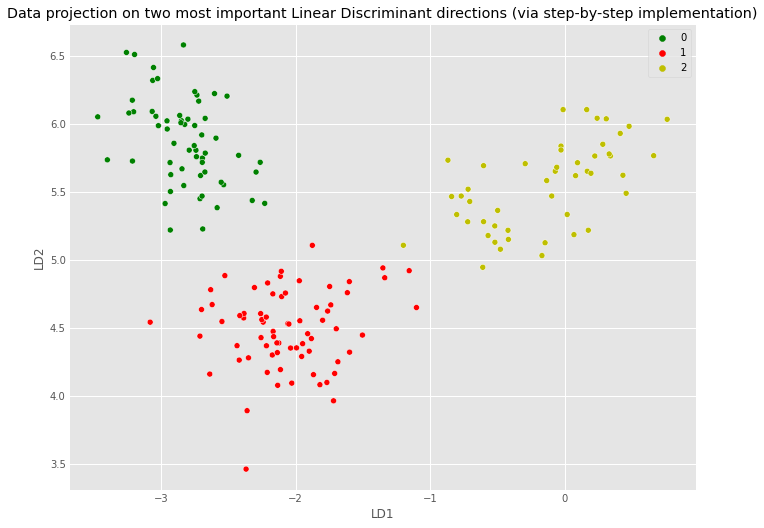

In [65]:
plt.style.use("ggplot")

plt.figure(figsize=(10,8))
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Data projection on two most important Linear Discriminant directions (via step-by-step implementation)')
#plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y, cmap='rainbow', alpha=0.7, edgecolors='k')
sns.scatterplot(x=X_transformed[:,0], y=X_transformed[:,1], hue=y, palette=["g", "r", "y"])

## Implementation with sklearn

In [66]:
LDA = LinearDiscriminantAnalysis(solver='eigen')
data_transformed = LDA.fit_transform(X, Y)

In [67]:
LDA.explained_variance_ratio_

array([0.6875, 0.3125])

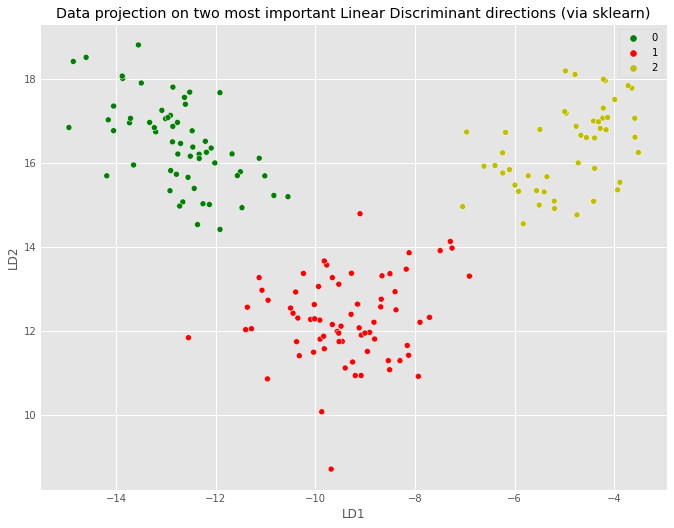

In [68]:
plt.figure(figsize=(10,8))
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('Data projection on two most important Linear Discriminant directions (via sklearn)')
sns.scatterplot(x=data_transformed[:,0], y=data_transformed[:,1], hue=y, palette=["g", "r", "y"])

### PCA x LDA

In many situations we don't want just to see the space with the most significant components (PCA), instead we want to check the space in which the "separability" (regarding to some classification problem) is maximized, therefore we should use LDA. 

It's also worth to mention that PCA is an unsupervised learning algorithm, while LDA is a supervised one.

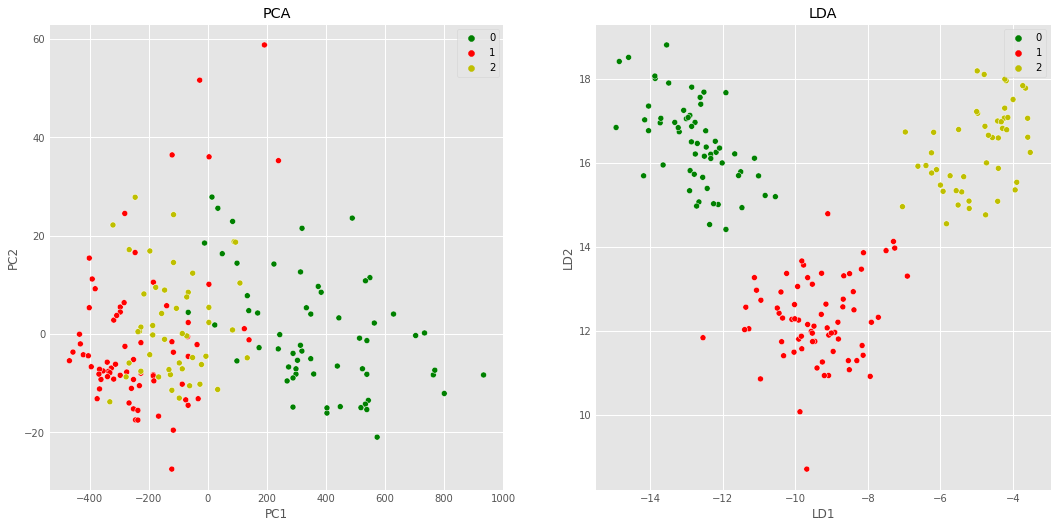

In [69]:
projection = PCA(n_components=2)
data2d = projection.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

ax1.set_title('PCA')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
sns.scatterplot(x=data2d[:,0], y=data2d[:,1], hue=y, palette=["g", "r", "y"], ax=ax1)

ax2.set_title('LDA')
ax2.set_xlabel('LD1')
ax2.set_ylabel('LD2')
sns.scatterplot(x=data_transformed[:,0], y=data_transformed[:,1], hue=y, palette=["g", "r", "y"], ax=ax2)

## LDA as a preprocessing tool 

Similarly to PCA, LDA can be used as a preprocessing tool for further usage of classification algorithms, such as Decisions Trees. Below we'll see the diference between using Decision Tree in the data with and without being exposed to LDA transformation

In [70]:
#Decision Tree with LDA

X_train, X_test, y_train, y_test = train_test_split(data_transformed, y, random_state=111)
clf1 = DecisionTreeClassifier(max_depth=3)
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)

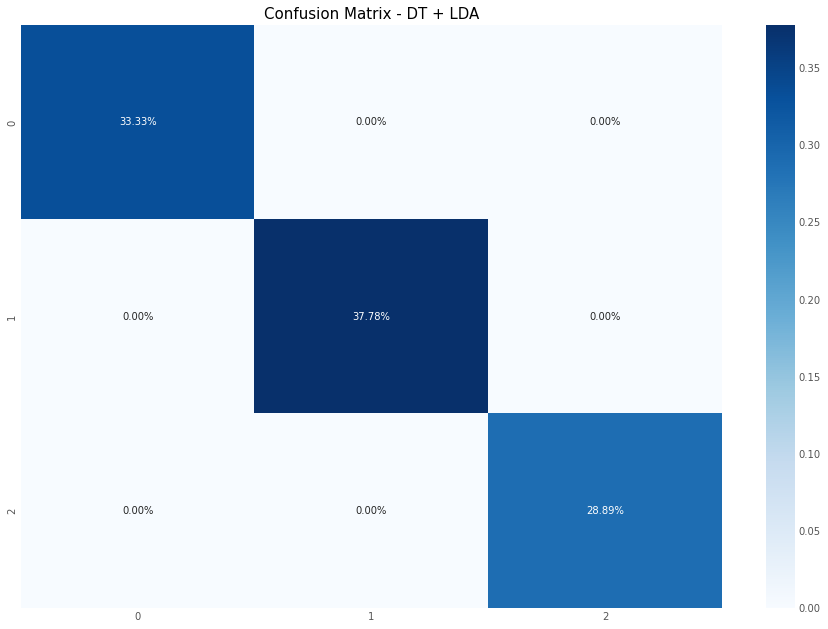

In [71]:
plt.figure(figsize=(14,10))
plt.title('Confusion Matrix - DT + LDA', fontsize=(15))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

No mistakes were made with this approach. Let's see what happens if we **don't** use LDA

In [72]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=111)
clf2 = DecisionTreeClassifier(max_depth=3)
clf2.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)

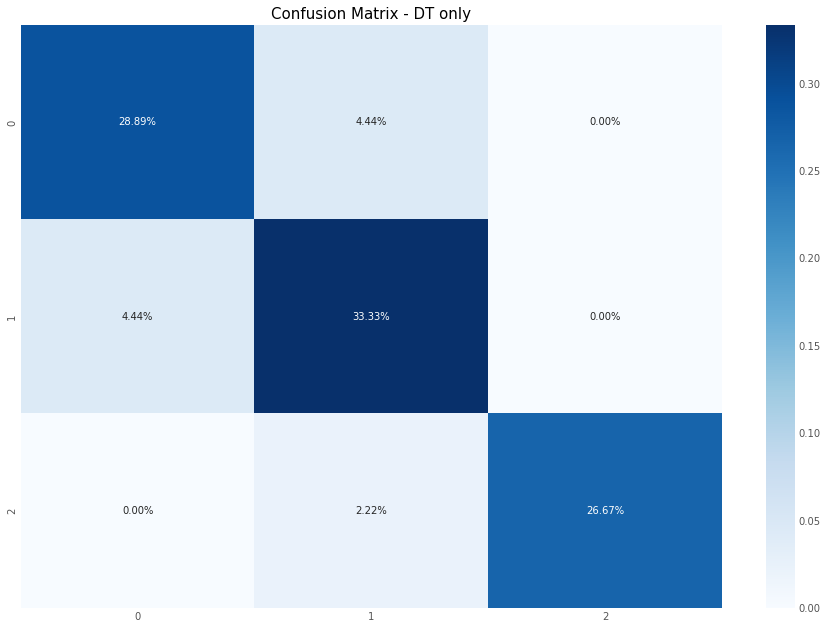

In [73]:
plt.figure(figsize=(14,10))
plt.title('Confusion Matrix - DT only', fontsize=(15))
cf_matrix = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

We clearly see that the model accuracy dropped off when the data wasn't transformed with LDA

## References

Fisher Linear Discriminant Analysis - Max Welling - Department of Computer Science - University of Toronto

Prof Olga Veksler Lectures - CS434a/541a: Pattern Recognition - University of Waterloo

Prof Dimity Kobak Lectures - Machine Learning 1 - Universitat Tubingen

https://sebastianraschka.com/Articles/2014_python_lda.html

https://yangxiaozhou.github.io/data/2019/10/02/linear-discriminant-analysis.html